<a href="https://colab.research.google.com/github/KutuDev/DataCentricAIComp/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Announcement worksheet](https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6)

[Leaderboard](https://https-deeplearning-ai.github.io/data-centric-comp/?utm_source=thebatch&utm_medium=newsletter&utm_campaign=dc-ai-competition&utm_content=dl-ai)

[Data inspection discoveries](https://drive.google.com/file/d/162_c0DDd9UdTN206I9Q7A6TmJg3Fay96/view?usp=sharing)

**Results**
* 1. *Baseline dataset*
        * Final acc: 0.67, Test acc: 0.52
        * Final loss: 0.94, Test loss: 1.38

* 2. *Data v2*
        * Final acc: 0.78, Test acc: 0.69
        * Final loss: 0.93, Test loss: 1.66

**To-Dos**

**Aim:** 0.95+ accuracy 

✅Train the resnet baseline model on their 3k plus data towards obtaining the 0.65 accuracy score. This might require include using their 32 by 32 pixel script for image resizing, deleting corrupted files, and fixing labels.

✅Inspect the 3k+ images for bad labels, bad image, etc. Fix all anomalies found. 

✅Download and read papers that uses the Roman MNIST dataset. We can get links to the dataset and other useful information.  


✅Inspect the image classes distribution and take necessary actions. It's important that the dataset isn't skewed. 

✅Use fastai's image data augmentation functions 

✅Gather more Roman MNIST data in an increase rate of not more than 10x of the 3k data size. This data gathering can be done using any means available, web scraping inclusive.

**N.B:** At the end of each steps above, we retrain the baseline model on the dataset in order to observe the effect on the model accuracy score.

# Notes

* RENAME EACH FILES. Add an auto-increment serial number at the start of each names. This would aid easy lookup of images. Doing this will require creating a doc that contains the previous and new name.
* the noise on some images can be erased using photo editing tools. This tool can also be used for data augmentation such as crop, resize.
* the images labelled as 'trash' in [Data inspection discoveries](https://drive.google.com/file/d/162_c0DDd9UdTN206I9Q7A6TmJg3Fay96/view?usp=sharing) should be moved to a new folder having a new class named 'unrecognized'

* in the I folder, there are images that look like small figure 1
* some images needs to be cropped
* some images have 1/2 vertical noisy lines
* in the II folder, some images written with marker are so small, hence, they appear like roman numeral I.
* in the II folder, some images have a bottom vertical noisy line
* images' stroke are either thick or thin
* some images are small lettered roman numeral 
* some images are capital lettered roman numeral
* some images are capita+bars lettered roman numeral
* some images are dashes
* images are black on white background

In [1]:
!git clone https://github.com/KutuDev/DataCentricAIComp

Cloning into 'DataCentricAIComp'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 48 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [2]:
def unzipper(in_folderPath, out_folderPath):
    import tarfile

    file = tarfile.open(in_folderPath)
    file.extractall(out_folderPath)
    file.close()

In [3]:
dataset_name = 'data_v2' 

unzipper(in_folderPath=f'/content/DataCentricAIComp/{dataset_name}.tar.gz', out_folderPath='./images')
unzipper(in_folderPath='/content/DataCentricAIComp/label_book.tar.gz', out_folderPath='./images')

In [ ]:
# import shutil

# shutil.move(f"/content/images/Users/Samuel/Desktop/{dataset_name}", "/content/images")

In [ ]:
# !pip install pysimplegui

In [ ]:
# !apt-get install -y xvfb # Install X Virtual Frame Buffer
# import os
# os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
# os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0

In [ ]:
# !python '/content/DataCentricAIComp/annotgui.py'

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

directory = "/content/images" 
user_data = directory + f"/{dataset_name}"
valid_data = directory + f"/{dataset_name}"
test_data = directory + "/label_book" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)


if __name__ == "__main__":
    train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
    if total_length > 10_000:
        print(f"Dataset size larger than 10,000. Got {total_length} examples")
        sys.exit()

    test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,
    )
    base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs, x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    model.summary()
    loss_0, acc_0 = model.evaluate(valid)
    print(f"loss {loss_0}, acc {acc_0}")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train,
        validation_data=valid,
        epochs=100,
        callbacks=[checkpoint],
    )

    model.load_weights("best_model")

    loss, acc = model.evaluate(valid)
    print(f"final loss {loss}, final acc {acc}")

    test_loss, test_acc = model.evaluate(test)
    print(f"test loss {test_loss}, test acc {test_acc}")

Found 1892 files belonging to 10 classes.
Found 813 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)         0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________

In [ ]:
# import os
# import tarfile
# def tardir(path, tar_name):
#     os.chdir(r'C:\Users\Samuel\Desktop')
#     with tarfile.open(tar_name, "w:gz") as tar_handle:
#         for root, dirs, files in os.walk(path):
#             for file in files:
#                 tar_handle.add(os.path.join(root, file))
# tardir('data_v2', 'data_v2.tar.gz')
# tar.close()

In [16]:
print(len(y_pred_labels))
len(y_pred_labels) == len(valid.file_paths)

813


True

In [76]:
import cv2
import matplotlib.pyplot as plt

def inspect_predictions(valid, rows=2, cols=3, figsize=(10,10)):
    imgs = valid.file_paths
    y_test_labels = [i.split('/')[-2] for i in imgs]
    classes = valid.class_names
    y_pred = [np.argmax(i) for i in model.predict(valid)]
    y_pred_labels = [classes[i] for i in y_pred]

    n = 0
    nrows = rows
    ncols = cols
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=figsize, constrained_layout = True)
 
    for row in range(nrows):
        for col in range(ncols):
            ax[row,col].set_title(f"Predicted label: {y_pred_labels[n]}\nTrue label: {y_test_labels[n]}")
            ax[row,col].imshow((cv2.imread(imgs[n])))
            n += 1

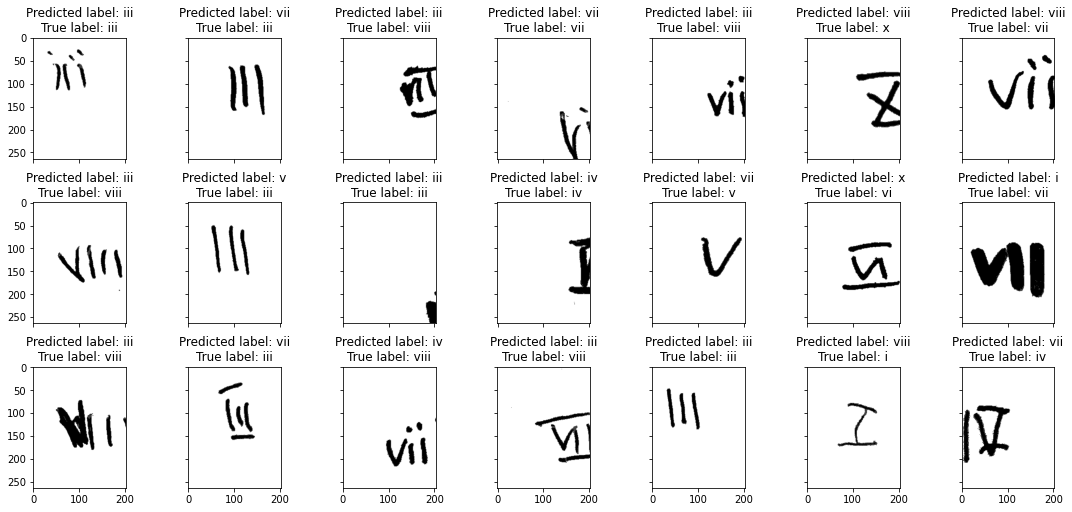

In [77]:
inspect_predictions(valid, rows=3, cols=7, figsize=(15,7))

In [22]:
# dir(valid)

In [ ]:
# tf.math.confusion_matrix(labels=b,predictions=y_pred_labels)
# dir(valid)